## Extreme value fitting and estimating return periods 
What's in this notebook:

1) How to read in data from a text file using Pandas 

2) How to fit annual maxima to an extreme value function to estimate return period 

3) How to use parallel for loops to speed up the same process at a global scale

*Note: likely need to install joblib:* `conda install joblib`

In [1]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from scipy.stats import genextreme as gev
from joblib import Parallel, delayed
import datetime


---

## (1) Read in data

Individual gauge-based records of daily river discharge from the Global Runoff Data Center are saved as column seperated text files. 
* These files contain 40 lines of header information (i.e., location name, river basin, catchment area, coordinates, etc.) 
* The files then have five columns of data: date (string), hour:minute of observation, original (non-corrected) data, calculated data (may have been corrected by GRDC), and a data quality flag.  


One of the easiest ways to read those in is using pandas, which reads the text file columns and saves them in a dataframe.


In [2]:
## ---- Load in river discharge data from text file ---- ##
fileName = '4127800.day'

#Read columns of data using pd.read_csv
data = pd.read_csv(fileName, sep=";",header=40,names=['Date','HH:MM','Original','Calculated','Flag'])

# Pull out dates, converted them using the datetime module
dates = data['Date'].values
dates_converted = np.array( [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates] )

Print a bit of the imported data (which is a pandas DataFrame object), just to inspect it:

In [3]:
data[0:10]

,Date,HH:MM,Original,Calculated,Flag
0,1931-10-01,--:--,4474.062,4474.062,-999
1,1931-10-02,--:--,4360.794,4360.794,-999
2,1931-10-03,--:--,4247.527,4247.527,-999
3,1931-10-04,--:--,4219.210,4219.210,-999
4,1931-10-05,--:--,4360.794,4360.794,-999
5,1931-10-06,--:--,4587.329,4587.329,-999
6,1931-10-07,--:--,4955.448,4955.448,-999
7,1931-10-08,--:--,5323.567,5323.567,-999
8,1931-10-09,--:--,5578.419,5578.419,-999
9,1931-10-10,--:--,5663.370,5663.370,-999


Convert the dates in place, and pull out the values

In [4]:
data['Date'] = data['Date'].str.split('-') #Dates stored as 'Year-Month-Day', so separate by '-' 

#Get lat and lon of GRDC station [skipped as part of the header when reading in full text file]
with open(fileName,"r", encoding="latin-1") as fi:
    for ln in fi:
        if ln.startswith("# Latitude (dec. °)"):
            latGRDC=float(ln[25:])
        if ln.startswith("# Longitude (de. °)"):
            lonGRDC=float(ln[25:])
            
#Separate year, month, and day  
year  = np.full([len(data)],np.nan)  #Define empty arrays 
month = np.full([len(data)],np.nan)
day   = np.full([len(data)],np.nan)

for it in range(len(data['Date'])):
    year[it]  = np.asarray(data['Date'][it][0],dtype=int)
    month[it] = np.asarray(data['Date'][it][1],dtype=int)
    day[it]   = np.asarray(data['Date'][it][2],dtype=int)

#GRDC calculated river discharge at this station 
calc = data.Calculated.values

#Remove missing data and replace with NaN 
calc[np.where(calc==-999)]=np.nan
calc[np.where(calc==999)]=np.nan
          

To confirm that we have the appropriate data (goal is to look at discharge near the mouth of the Mississippi River), we can plot the location of the river gauge: 

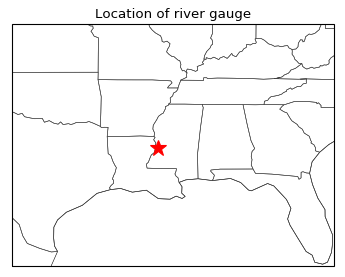

In [5]:
#Show location of GRDC station 
fig=plt.figure(figsize=(8,4), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-100,-80,25,40])   ##Centered on US for the Mississippi
#Add figure title, coastlines, etc. 
ax.set_title('Location of river gauge')
ax.title.set_fontsize(12)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor='0.25')
#Add dot for GRDC station 
ax.plot(lonGRDC,latGRDC,color='Red',linestyle='none',marker='*',markersize=15)


Make a quick plot of this time series to get a visual sense of the values.

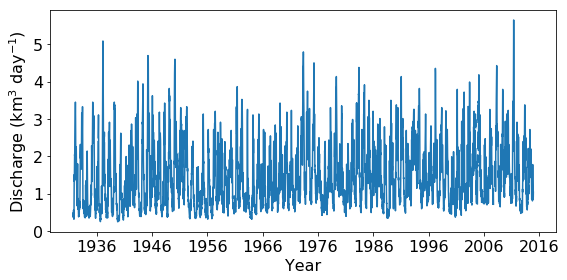

In [8]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(111)
ax.plot(dates_converted, calc*86400./1e9)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Discharge (km$^{3}$ day$^{-1}$)', fontsize=16)
ax.tick_params(labelsize=16)

#Uncomment line below to only show data from 1970 to 2000
#ax.set_xlim(datetime.datetime(1970,1,1), datetime.datetime(1999,12,31))

fig.tight_layout()


---

## (2) Calculate annual maxima, fit to extreme value distribution

### To compute return period of extreme river discharges, we need to know the annual maximum flow

Typically, 30 years are used for fitting to extreme value distributions when estimating flow (i.e., river flood) return periods. 
* So we select a recent 30-year period (1970-2000) and compute the annual maximum in each case.
* Observations include Feb. 29th during leap years, but we'll ignore those days here (using numpy.delete to remove data) to make things a bit easier


In [9]:
# --- Separate data into yearly arrays [30 years x 365 days] --- #

#Set range of years to consider 
maxYr = 2000
minYr = 1970

#Define empty array 
annFlow = np.full([maxYr-minYr,365],np.nan)

#Save individual years of data 
for iYr in range(maxYr-minYr):
    valData = np.where(year==(minYr+iYr))
    yearRiv = calc[valData]
    
    #Ignore Feb. 29 during leap years
    if len(yearRiv)==366: 
        iRem = np.where((month[valData]==2)&(day[valData]==29))
        yearRiv=np.delete(yearRiv,iRem)
    
    annFlow[iYr,:] = yearRiv 

#Isolate annual maxima 
annMax = np.nanmax(annFlow,axis=1)


### Computing the river flow associated with a 100-year return period 
There are a few extreme value distributions to choose from, but we'll try the most general form first: the Generalized Extreme Value distribution (GEV). 
* The GEV is characterized by three parameters: location(M), scale(S), and shape (K). 
* Those parameters are estimed by genextreme.fit
* To get the actual magnitude associated with a certain return period, invert the CDF using genextreme.ppf 

*Documentation for genextreme: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html* 


In [10]:
#Fit to the GEV distribution 
gev_fit = gev.fit(annMax)

#Extract distribution parameters from the fit 
K = gev_fit[0]
M = gev_fit[1]
S = gev_fit[2]

#Compute discharge associated with the 100 year food 
retPeriod = 100
R100 = gev.ppf((1-(1/retPeriod)),K,loc=M,scale=S)

#Print result 
print('The river discharge associated with a 100-year return period is %.2f km^3/day' %(R100*(1e-9)*86400.))


The river discharge associated with a 100-year return period is 14270210327.63 km^3/day


**But different fits may be a better match to your data. You can try out some alternate ones below.**

In [11]:
#Fit to an alternate (Gumbel, Frechet, or Gamma) distribution
from scipy.stats import gumbel_r as gev_alt
#from scipy.stats import frechet_r as gev_alt
#from scipy.stats import gamma as gev_alt

gev_fit_alt = gev_alt.fit(annMax)

#Compute discharge associated with the 100 year food 
retPeriod = 100
R100_alt = gev_alt.ppf((1-(1/retPeriod)), *gev_fit_alt)

#Print result 
print('The river discharge associated with a 100-year return period is %.2f km^3/day' %(R100_alt*(1e-9)*86400.))


The river discharge associated with a 100-year return period is 5.57 km^3/day


**Compare the two options for a statistical fit to observed streamflow:**

In [12]:
#Create histogram, add 10% padding to bins using min/max values of annMax
bins = np.linspace(annMax.min()-.1*annMax.min(), annMax.max()+.1*annMax.max(), 20)
hist_values, bin_edges = np.histogram(annMax, bins=bins, density=True)

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_width = np.diff(bin_edges)

Plot the GEV fit to see how it did

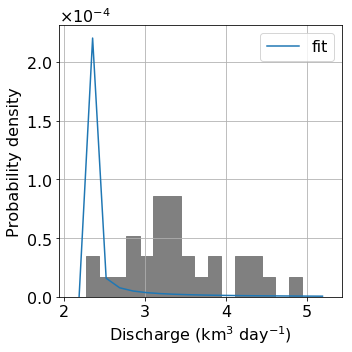

In [13]:
#Calculate the fitted distribution
gev_fit_distro = gev.pdf(bin_centers, *gev_fit)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
#Add histogram
ax.bar(bin_centers*86400./1e9, hist_values, align='center', width=bin_width*86400./1e9, color='0.5', edgecolor='0.5')
#Add fitted distribution
ax.plot(bin_centers*86400./1e9,gev_fit_distro, label='fit')

ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(16)
ax.set_ylabel('Probability density', fontsize=16)
ax.set_xlabel('Discharge (km$^3$ day$^{-1}$)', fontsize=16)
ax.grid()

ax.legend(fontsize=16)

fig.tight_layout()

Do same for alternate distribution option

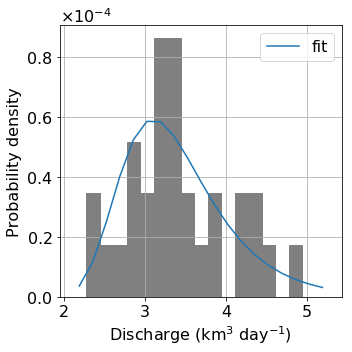

In [14]:
#Calculate the fitted distribution
gev_fit_distro = gev_alt.pdf(bin_centers, *gev_fit_alt)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
#Add histogram
ax.bar(bin_centers*86400./1e9, hist_values, align='center', width=bin_width*86400./1e9, color='0.5', edgecolor='0.5')
#Add fitted distribution
ax.plot(bin_centers*86400./1e9,gev_fit_distro, label='fit')

ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(16)
ax.set_ylabel('Probability density', fontsize=16)
ax.set_xlabel('Discharge (km$^3$ day$^{-1}$)', fontsize=16)
ax.grid()

ax.legend(fontsize=16)

fig.tight_layout()

---

## (3) Do the same on more data in parallel!

### If we had a larger dataset, we might want to speed up this process by using a parallel loop
To illustrate, I've included a dataset with global annual maximum river discharge from a high-resolution modeling experiment. 
<br>*Note: This was saved as a pickle to avoid loading unnecessary data from the original files (see https://docs.python.org/3/library/pickle.html, https://wiki.python.org/moin/UsingPickle)*

In [15]:
# Dataset that already has annual maxima picked out at every location 
[maxYearly,lat,lon] = np.load('dischargeData.pkl')

print('Shape of global discharge data: ',np.shape(maxYearly))
print()
print('Without parallel loop, process could theoretically take up to %.2f hours' %((219*0.001/60/60)*720*1440)) #Hours to run above*numLat*numLon


Shape of global discharge data:  (1440, 720, 30)

Without parallel loop, process could theoretically take up to 63.07 hours


To illustrate the benefit of parallel loops, we'll use a small subset of the full global data (e.g, a 20th of the full longitudes). 

First, we'll compute the magnitude of the 100-year river discharge without using a parallel for loop. 
<br>This calculation needs to be carried out at every grid cell individually, so we'll loop over longitude and latitude and carry out the same process as above to estimate R100. 

In [16]:
## --- Without using a parallel loop --- ## 

#Define empty array to store return period discharge 
R100_global = np.full([len(lon),len(lat)],np.nan)
retPeriod = 100

#Compute 100-year return period discharge at every location 
for ilon in range(int(len(lon)/20)):
    for ilat in range(len(lat)): 
        
        # Check for NaN to make sure there's actual data at this location 
        validCount = np.count_nonzero(~np.isnan(maxYearly[ilon,ilat,:]))
              
        if validCount>5:             
            #Fit annual maxima to GEV 
            gev_fit = gev.fit(maxYearly[ilon,ilat,:])
            K = gev_fit[0]
            M = gev_fit[1]
            S = gev_fit[2]
            #Compute return period 
            R100_global[ilon,ilat] = gev.ppf((1-(1/retPeriod)),K,loc=M,scale=S)
    
    #Print progress report 
    if np.remainder(ilon,10)==0:
        print('Now on lon... ', ilon) 

Now on lon...  0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


Now on lon...  10
Now on lon...  20
Now on lon...  30
Now on lon...  40
Now on lon...  50
Now on lon...  60
Now on lon...  70



*Note: Some error messages are likely going to appear. In general, these warnings don't seem to impact the results in any way and are a result of working with very large and very small numbers.* <br>
    
### Parallel looping in Python 
One of the best tools for parallel for loops is joblib.Parallel (https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html, https://joblib.readthedocs.io/en/latest/parallel.html). 
* First, define a function that needs to be carried out a large number of times. In our case, that will be computing the R100 value over all latitudes for a given longitude value. The order in which this function is called **cannot** matter - that is, the result of the second loop iteration cannot be dependent on the first. If there is that dependency, it's not possible to split up the calculation with parallel loops.
* Next, use `Parallel` to run that function repeatedly on separate processors. You can specity the number of CPUs to split this process over with `n_jobs`. On a personal laptop like a Macbook Pro, 2 seems like a pretty reasonable number, but this can be higher on supercomputers. 



In [17]:
## --- Define function to compute magntiude of 100-year discharge --- ## 

def compute100yrMagnitude(recArray,i):
    
    #Print progress update 
    if np.remainder(i,10)==0:
        print('Now on lon...', i) 
        
    #Define empty temporary array 
    R100_ctrlInt = np.full([len(lat)],np.nan)

    for j in range(len(lat)):   
        rec     = recArray[j,:]  #Isolate singe latitude within the record supplied 
        validCount = np.count_nonzero(~np.isnan(rec)) # Check for NaN to make sure there's enough data 
            
        if validCount>5:        
            #Fit GEV at this location 
            gev_fit = gev.fit(rec)
            K = gev_fit[0]
            M = gev_fit[1]
            S = gev_fit[2]
    
            #Compute discharge of 100-year flood 
            R100_ctrlInt[j] = gev.ppf((1-(1/retPeriod)),K,loc=M,scale=S)           
    
    return R100_ctrlInt

In [18]:
## --- Execue parallel loop --- ## 

#Define return period
retPeriod = 100.0

#Parallel loop on 2 CPUs (specified by n_jobs)
R100_ctrl = Parallel(n_jobs=4)(delayed(compute100yrMagnitude)(maxYearly[i,:,:],i) for i in range(int(len(lon)/20)))


Now on lon... 0


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


Now on lon... 10


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2175: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


Now on lon... 20
Now on lon... 30


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


Now on lon... 40


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:412: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


Now on lon... 50
Now on lon... 60
Now on lon... 70


So using a parallel loop to compute return period magnitude allows us to cut the time used up in half when n_jobs is set to 2. When there are more CPUs available for splitting over this can be reduced even further, which is necessary when handling large datasets like this. 

### To show that both approaches result in the same R100 values, we can plot them side by side: 

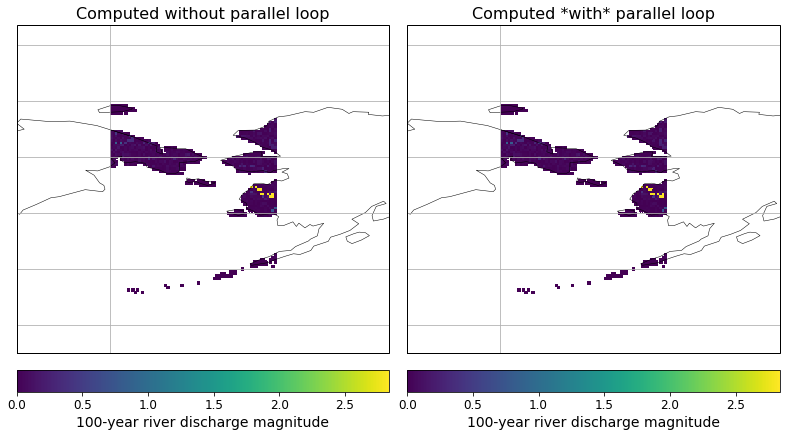

In [19]:
#Show the results from each 

map_proj = ccrs.PlateCarree(central_longitude=180)
data_proj = ccrs.PlateCarree()

# --- Set up figure window --- 
fig, ax_array = plt.subplots(1,2,subplot_kw={'projection':map_proj})
ax1,ax2 = ax_array.flatten()
fig.set_size_inches(11,5)

#Subplot 1: Without parallel loop 
ax1.set_extent([-190,-150,45,80])
contour_plot1 = ax1.pcolormesh(lon[0:int(len(lon)/20)],lat,np.transpose(R100_global[0:int(len(lon)/20),:]), \
                              transform=data_proj)
ax1.set_title('Computed without parallel loop')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


#Subplot 2: WITH parallel loop 
ax2.set_extent([-190,-150,45,80])
contour_plot2 = ax2.pcolormesh(lon[0:int(len(lon)/20)],lat,np.transpose(R100_ctrl), \
                              transform=data_proj)
ax2.set_title('Computed *with* parallel loop')
ax2.title.set_fontsize(16)
ax2.coastlines(linewidth=0.5,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

fig.tight_layout()

#Colorbar 1 options 
ax_position = ax1.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot1, orientation='horizontal',cax=cbar_ax)
cbar.set_label('100-year river discharge magnitude',fontsize=14)
cbar.ax.tick_params(labelsize=12)

#Colorbar 2 options 
ax_position = ax2.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot2, orientation='horizontal',cax=cbar_ax)
cbar.set_label('100-year river discharge magnitude',fontsize=14)
cbar.ax.tick_params(labelsize=12)